### Objective

1. Introduce the concept of SSL
2. Compare the performance on CIFAR10 dataset:
    - CNN on small labelled dataset
    - CNN on small labelled dataset + augmentation
    - CNN on small labelled dataset + SSL on large unlabelled dataset
    - CNN on small labelled dataset + SSL on large unlabelled dataset + augmentation

In [8]:
%pip install einops

Note: you may need to restart the kernel to use updated packages.


In [91]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
%matplotlib inline
# Retina display
%config InlineBackend.figure_format = 'retina'

# Confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import einops
import torchsummary
from tqdm import tqdm

import umap



In [92]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [93]:
# Download the dataset
transform = transforms.Compose(
    [transforms.ToTensor()])

data_path = os.path.expanduser('~/.cache/torch/')

dataset = torchvision.datasets.CIFAR10(root=data_path, train=True, download=True, transform=transform)


Files already downloaded and verified


In [94]:
dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /home/nipun.batra/.cache/torch/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [95]:
dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

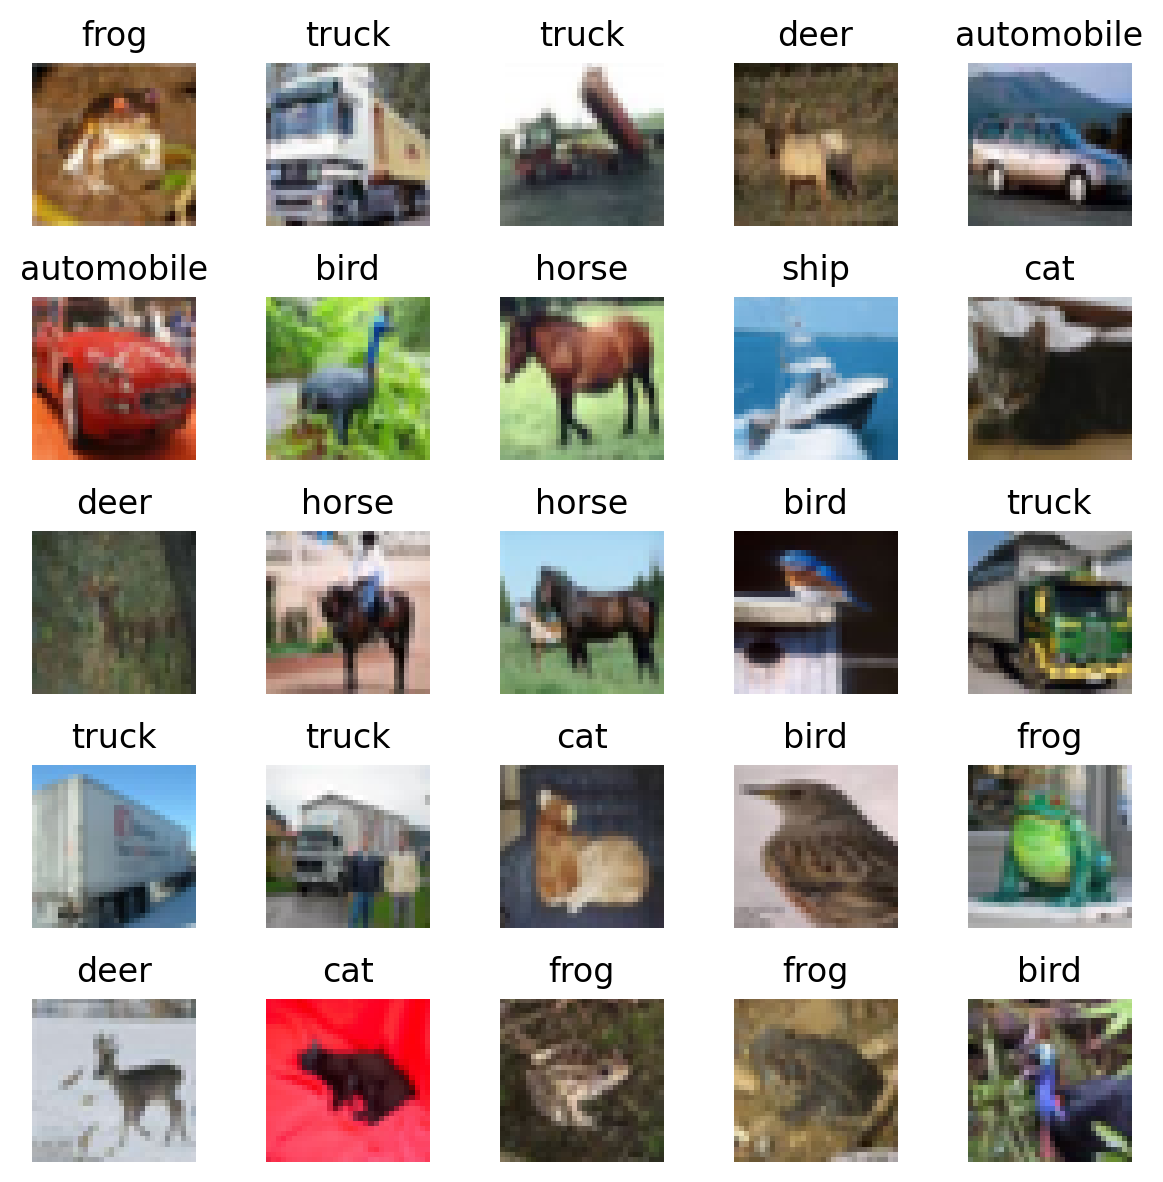

In [96]:
# Plot some images
plt.figure(figsize=(6, 6))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(dataset.data[i])
    plt.axis('off')
    plt.title(dataset.classes[dataset.targets[i]])
plt.tight_layout()

In [97]:
n_train = 1000
n_test = 20000

dataset = torchvision.datasets.CIFAR10(root="/tmp/cifardata", download=True)
transform = torchvision.models.ResNet18_Weights.DEFAULT.transforms()

# Use einops to convert from NHWC to NCHW

X = torch.tensor(dataset.data).float()
print(X.shape)
X = einops.rearrange(X, '... h w c -> ... c h w')
print(X.shape)

Files already downloaded and verified
torch.Size([50000, 32, 32, 3])
torch.Size([50000, 3, 32, 32])


In [98]:
print(X.min(), X.max())
X = X/255.0
print(X.min(), X.max())
y = torch.tensor(dataset.targets).long()
print(y.shape)

tensor(0.) tensor(255.)
tensor(0.) tensor(1.)
torch.Size([50000])


In [99]:
torch.manual_seed(0)
idx = torch.randperm(len(X))
train_idx = idx[:n_train]
pool_idx = idx[n_train:-n_test]
test_idx = idx[-n_test:]
print(len(train_idx), len(pool_idx), len(test_idx))

1000 29000 20000


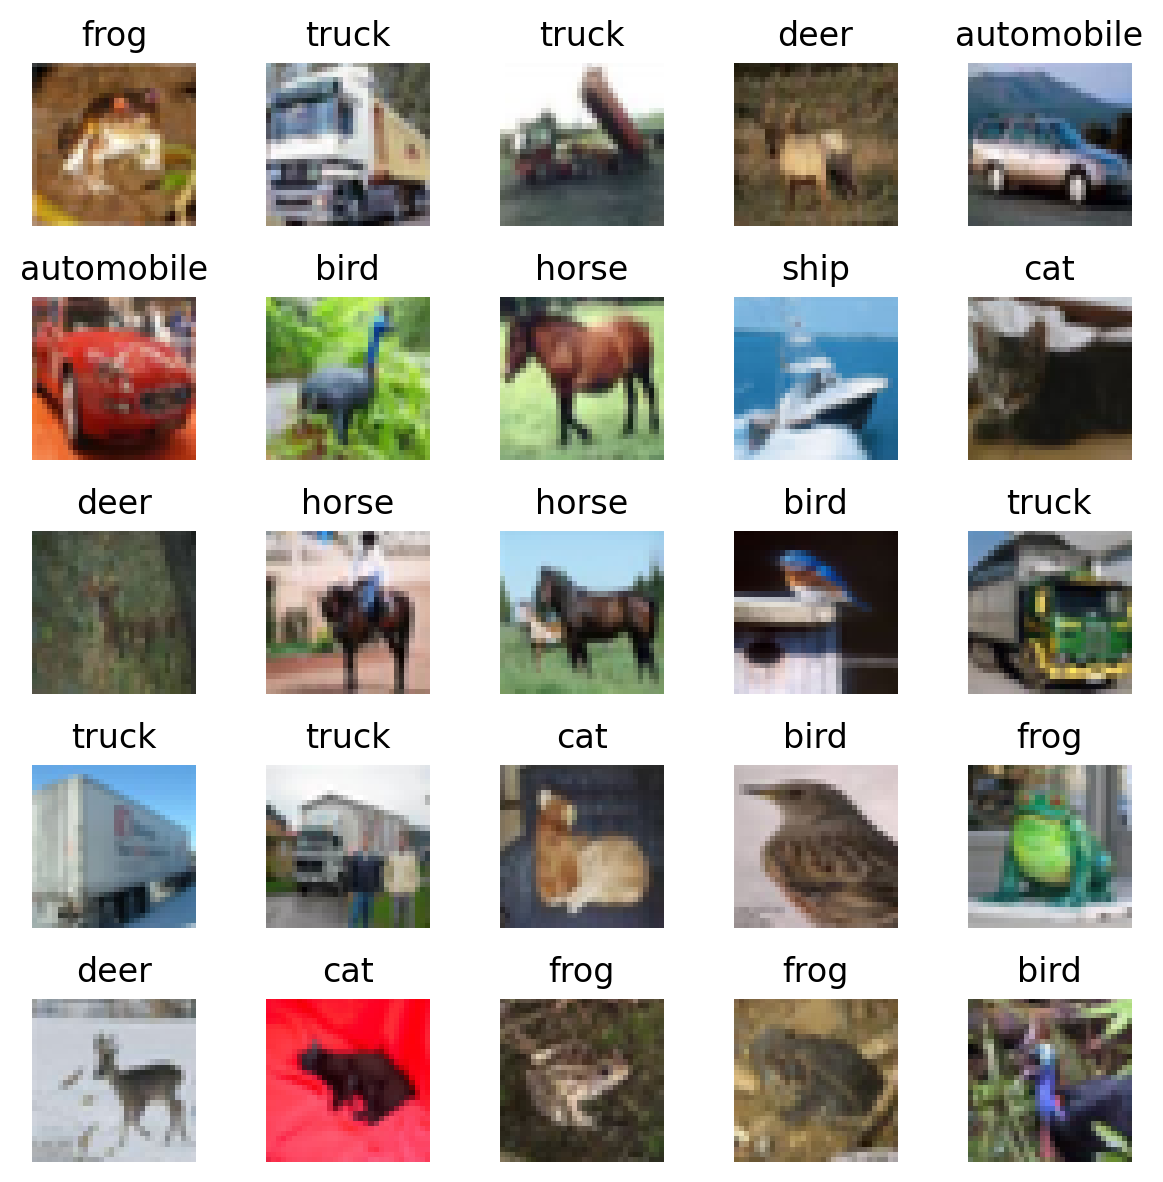

In [100]:
# Plot some images
plt.figure(figsize=(6, 6))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].cpu().permute(1, 2, 0))
    plt.axis('off')
    plt.title(dataset.classes[dataset.targets[i]])
plt.tight_layout()

In [101]:
class Featurizer(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torchvision.models.resnet18(weights=None)
        self.model.fc = nn.Identity() # remove the last layer
        
    def forward(self, x):
        x = self.model(x)
        return x
    
class Classifier(nn.Module):
    def __init__(self, n_classes, dropout):
        super().__init__()
        
        self.dropout = nn.Dropout(dropout, inplace=True)
        
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, n_classes)
        
    def forward(self, x):
        x = F.gelu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [102]:
class ResNetClassifier(nn.Module):
    def __init__(self, n_classes, dropout):
        super().__init__()
        self.featurizer = Featurizer()
        self.classifier = Classifier(n_classes, dropout)
        
    def forward(self, x):
        x = self.featurizer(x)
        x = self.classifier(x)
        return x
    
    def featurize(self, x):
        x = self.featurizer(x)
        return x
    
    def predict(self, x):
        x = self.forward(x)
        return x.argmax(-1)

In [103]:
resnet = ResNetClassifier(n_classes=10, dropout=0.1).to(device)

In [104]:
resnet

ResNetClassifier(
  (featurizer): Featurizer(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn

In [105]:
torchsummary.summary(resnet, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

train set accuracy: 9.70%


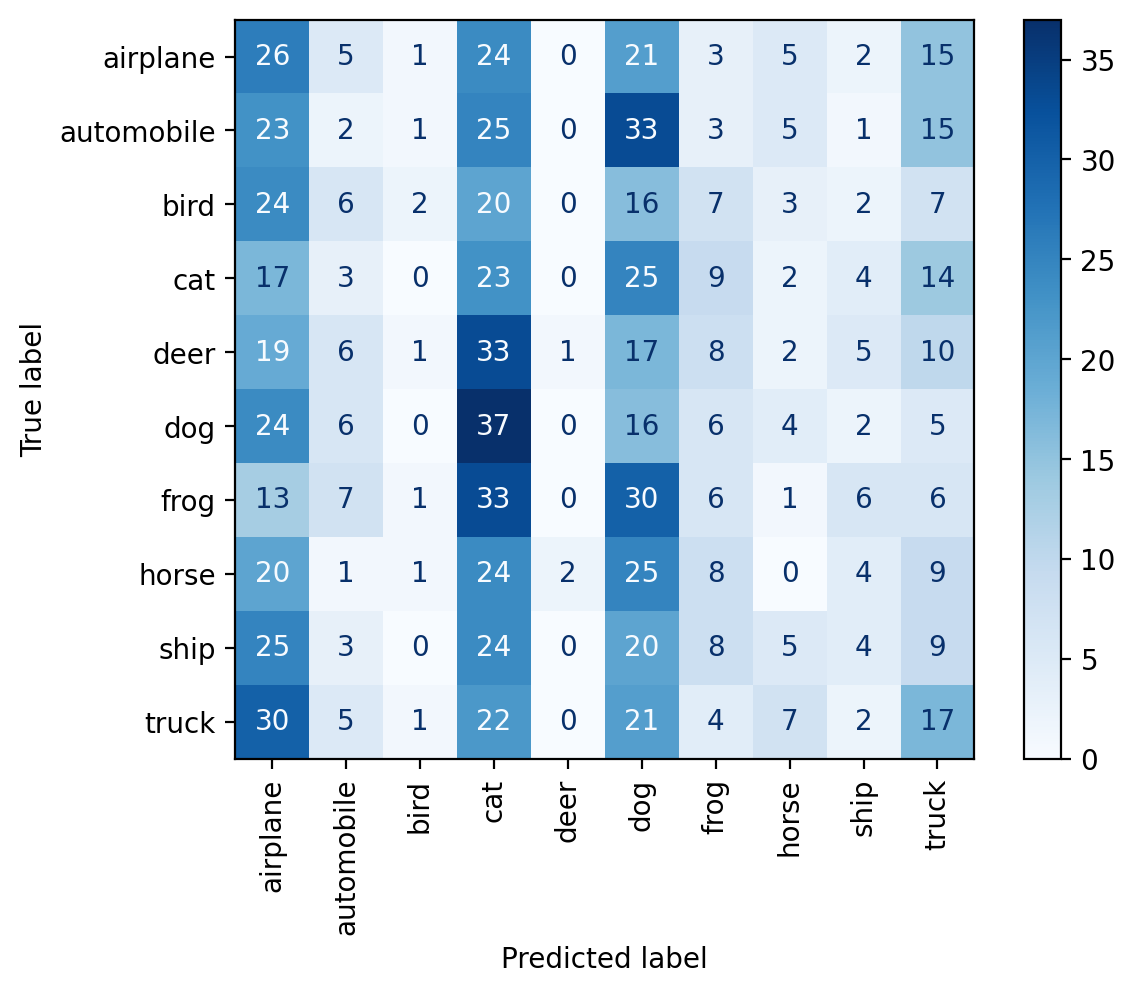

pool set accuracy: 10.80%


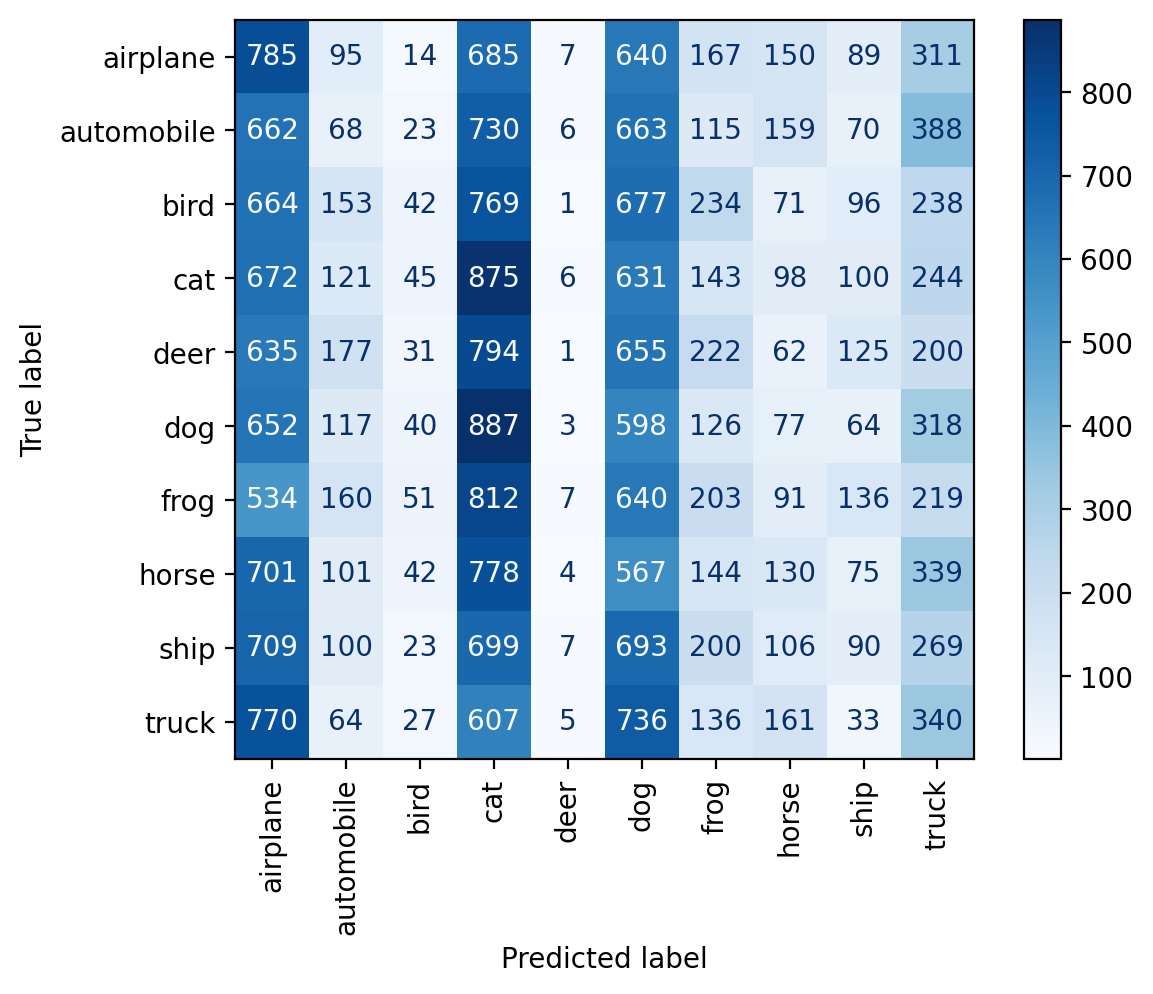

test set accuracy: 10.82%


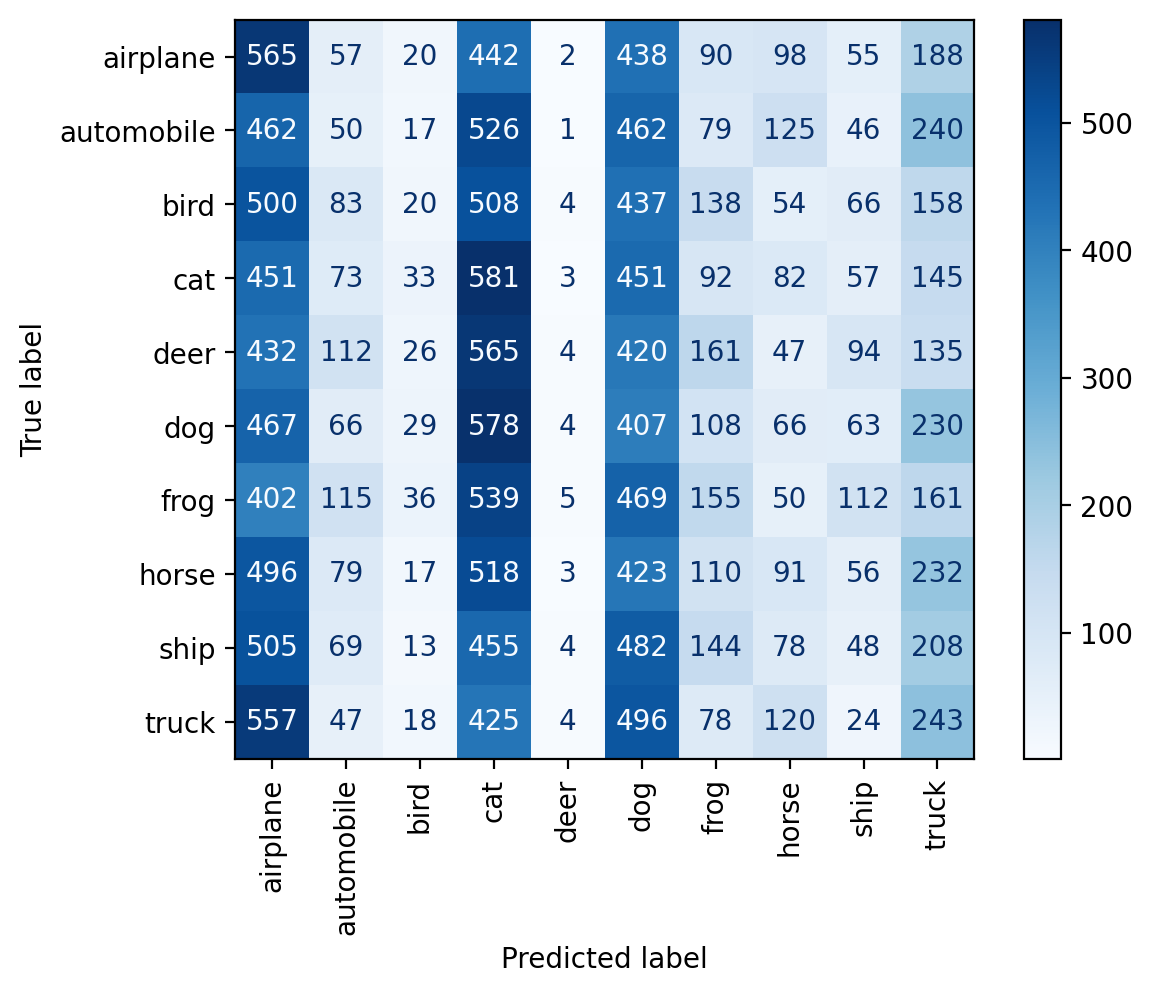

In [106]:
def get_accuracy(net, X, y):
    with torch.no_grad():
        logits_pred = net(X)
        y_pred = logits_pred.argmax(dim=1)
        acc = (y_pred == y).float().mean()
        return y_pred, acc

def predict(net, classes, plot_confusion_matrix=False):
    for i, (name, idx) in enumerate(zip(("train", "pool", "test"), [train_idx, pool_idx, test_idx])):
        X_dataset = X[idx].to(device)
        y_dataset = y[idx].to(device)
        y_pred, acc = get_accuracy(net, X_dataset, y_dataset)
        print(f'{name} set accuracy: {acc*100:.2f}%')
        if plot_confusion_matrix:
            cm = confusion_matrix(y_dataset.cpu(), y_pred.cpu())
            cm_display = ConfusionMatrixDisplay(cm, display_labels=classes).plot(values_format='d'
                                                                                , cmap='Blues')
            # Rotate the labels on x-axis to make them readable
            _ = plt.xticks(rotation=90)
            plt.show()

predict(resnet, dataset.classes, plot_confusion_matrix=True)

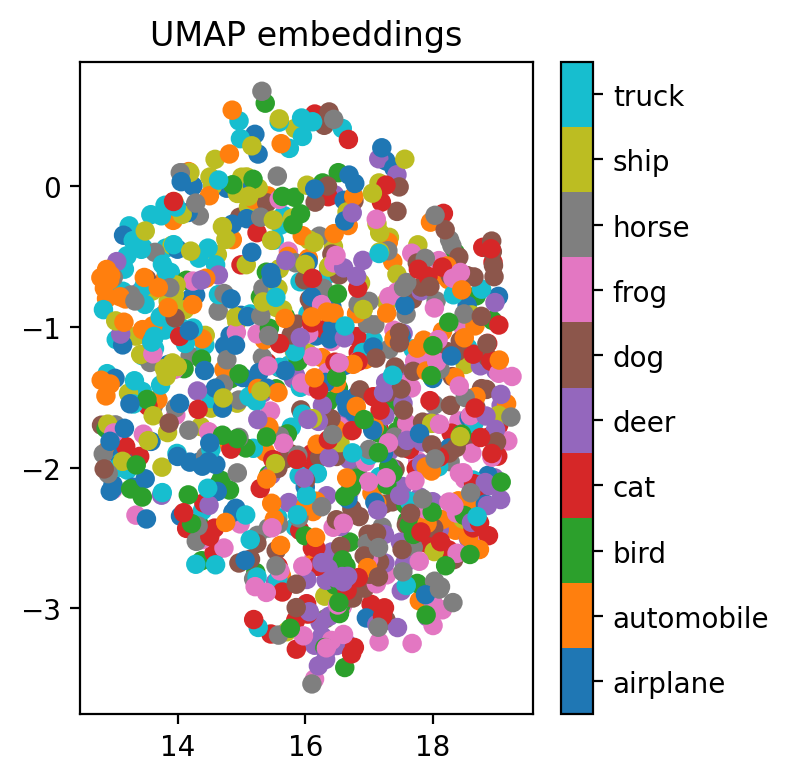

In [107]:
def viz_embeddings(net, X, y, device):
    reducer = umap.UMAP()
    with torch.no_grad():
        emb = net.featurizer(X.to(device))
    emb = emb.cpu().numpy()
    emb = reducer.fit_transform(emb)
    plt.figure(figsize=(4, 4))
    plt.scatter(emb[:, 0], emb[:, 1], c=y.cpu().numpy(), cmap='tab10')
    # Add a colorbar legend to mark color to class mapping
    cb = plt.colorbar(boundaries=np.arange(11)-0.5)
    cb.set_ticks(np.arange(10))
    cb.set_ticklabels(dataset.classes)
    plt.title("UMAP embeddings")
    plt.tight_layout()

viz_embeddings(resnet, X[train_idx], y[train_idx], device)

In [56]:
def train_fn(model, X, y, lr, batch_size, epochs, device):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    n_batches = len(X) // batch_size
    
    model.train()
    iter_losses = []
    epoch_losses = []
    for epoch in range(epochs):
        idx = torch.randperm(len(X))
        epoch_loss = 0
        pbar = tqdm(range(0, len(X), batch_size))
        for i in pbar:
            optimizer.zero_grad()
            batch_X = X[idx][i:i+batch_size].to(device)
            batch_y = y[idx][i:i+batch_size].to(device)
            logits = model(batch_X)
            loss = criterion(logits, batch_y)
            loss.backward()
            optimizer.step()
            iter_losses.append(loss.item())
            epoch_loss += loss.item()
            pbar.set_description(f"loss: {loss.item():.4f}")
        epoch_losses.append(epoch_loss / n_batches)
        print(f"Epoch {epoch+1}/{epochs} | Epoch loss: {epoch_loss / n_batches:.4f}")
        
    return iter_losses, epoch_losses

def predict_fn(model, X, batch_size, device):
    model.eval()
    with torch.no_grad():
        logits = []
        for i in tqdm(range(0, len(X), batch_size)):
            batch_X = X[i:i+batch_size].to(device)
            batch_logits = model(batch_X)
            logits.append(batch_logits.cpu())
        logits = torch.cat(logits)
    return logits

def get_classes(logits):
    return logits.argmax(-1)

#### Train the model on train set

In [108]:
iter_losses, epoch_losses = train_fn(resnet, X[train_idx], y[train_idx], lr=3e-4, 
                                     batch_size=128, epochs=18, device=device)

  0%|          | 0/8 [00:00<?, ?it/s]

loss: 2.0574: 100%|██████████| 8/8 [00:00<00:00, 49.79it/s]


Epoch 1/18 | Epoch loss: 2.4975


loss: 1.5904: 100%|██████████| 8/8 [00:00<00:00, 48.17it/s]


Epoch 2/18 | Epoch loss: 1.8804


loss: 0.8234: 100%|██████████| 8/8 [00:00<00:00, 52.19it/s]


Epoch 3/18 | Epoch loss: 1.1745


loss: 0.2925: 100%|██████████| 8/8 [00:00<00:00, 49.12it/s]


Epoch 4/18 | Epoch loss: 0.4801


loss: 0.1084: 100%|██████████| 8/8 [00:00<00:00, 51.56it/s]


Epoch 5/18 | Epoch loss: 0.1405


loss: 0.0249: 100%|██████████| 8/8 [00:00<00:00, 51.29it/s]


Epoch 6/18 | Epoch loss: 0.0425


loss: 0.0089: 100%|██████████| 8/8 [00:00<00:00, 55.98it/s]


Epoch 7/18 | Epoch loss: 0.0215


loss: 0.0088: 100%|██████████| 8/8 [00:00<00:00, 51.29it/s]


Epoch 8/18 | Epoch loss: 0.0168


loss: 0.0053: 100%|██████████| 8/8 [00:00<00:00, 55.70it/s]


Epoch 9/18 | Epoch loss: 0.0089


loss: 0.0068: 100%|██████████| 8/8 [00:00<00:00, 52.89it/s]


Epoch 10/18 | Epoch loss: 0.0145


loss: 0.0230: 100%|██████████| 8/8 [00:00<00:00, 55.11it/s]


Epoch 11/18 | Epoch loss: 0.0420


loss: 0.0517: 100%|██████████| 8/8 [00:00<00:00, 56.47it/s]


Epoch 12/18 | Epoch loss: 0.0399


loss: 0.1530: 100%|██████████| 8/8 [00:00<00:00, 57.70it/s]


Epoch 13/18 | Epoch loss: 0.0928


loss: 0.2616: 100%|██████████| 8/8 [00:00<00:00, 52.50it/s]


Epoch 14/18 | Epoch loss: 0.1365


loss: 0.3084: 100%|██████████| 8/8 [00:00<00:00, 51.77it/s]


Epoch 15/18 | Epoch loss: 0.2226


loss: 0.2824: 100%|██████████| 8/8 [00:00<00:00, 56.99it/s]


Epoch 16/18 | Epoch loss: 0.2203


loss: 0.3244: 100%|██████████| 8/8 [00:00<00:00, 54.12it/s]


Epoch 17/18 | Epoch loss: 0.2447


loss: 0.1653: 100%|██████████| 8/8 [00:00<00:00, 54.73it/s]

Epoch 18/18 | Epoch loss: 0.1575


train set accuracy: 100.00%


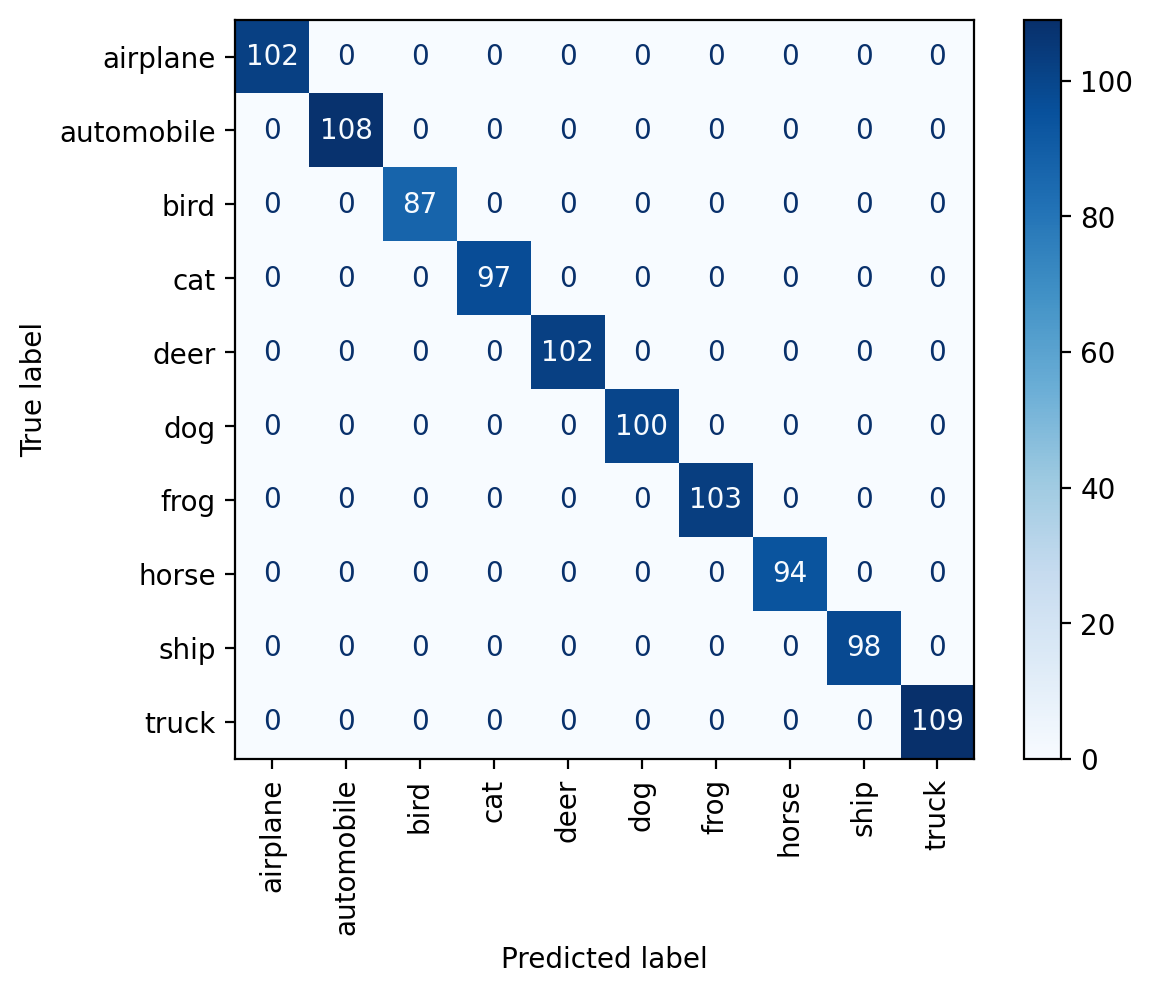

pool set accuracy: 34.36%


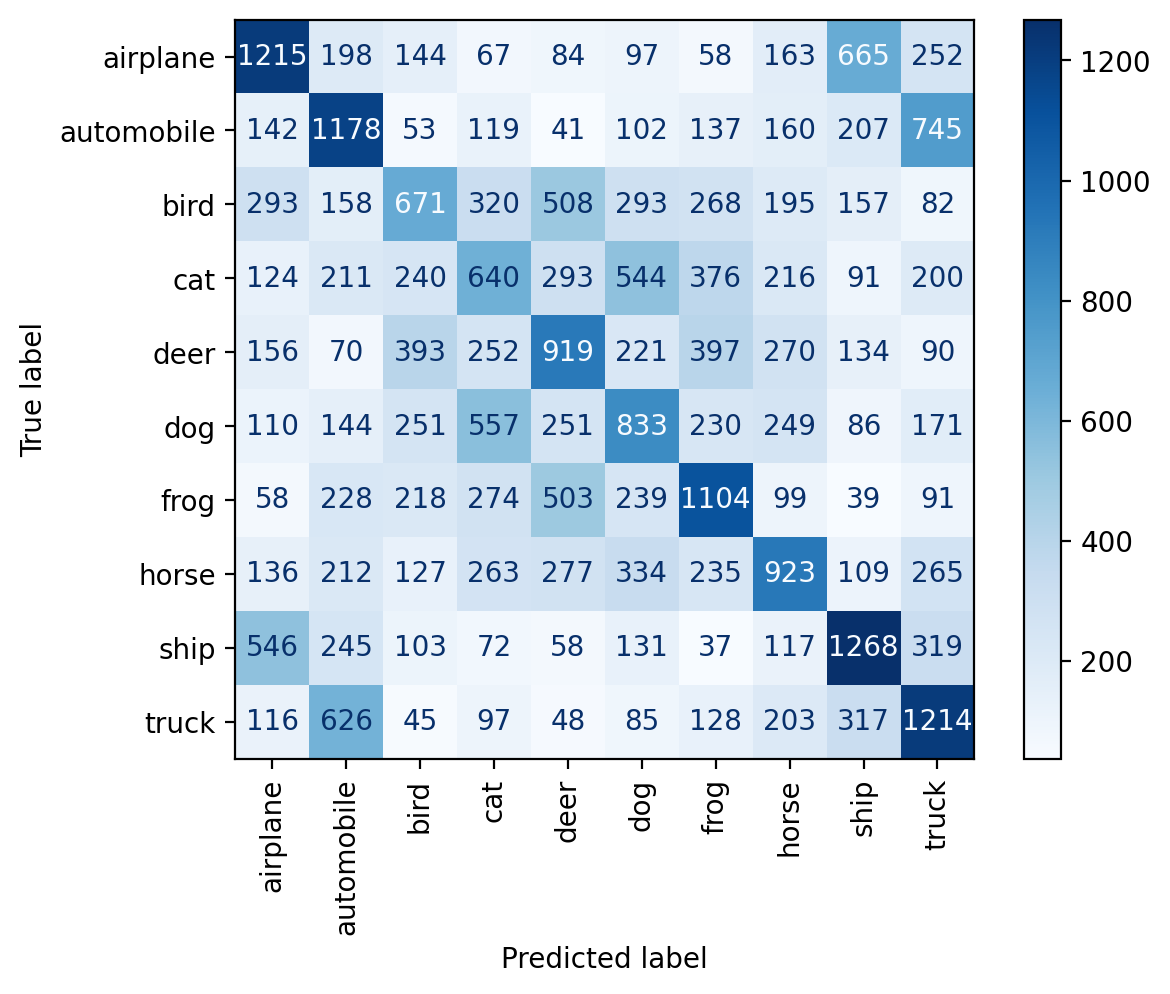

test set accuracy: 35.51%


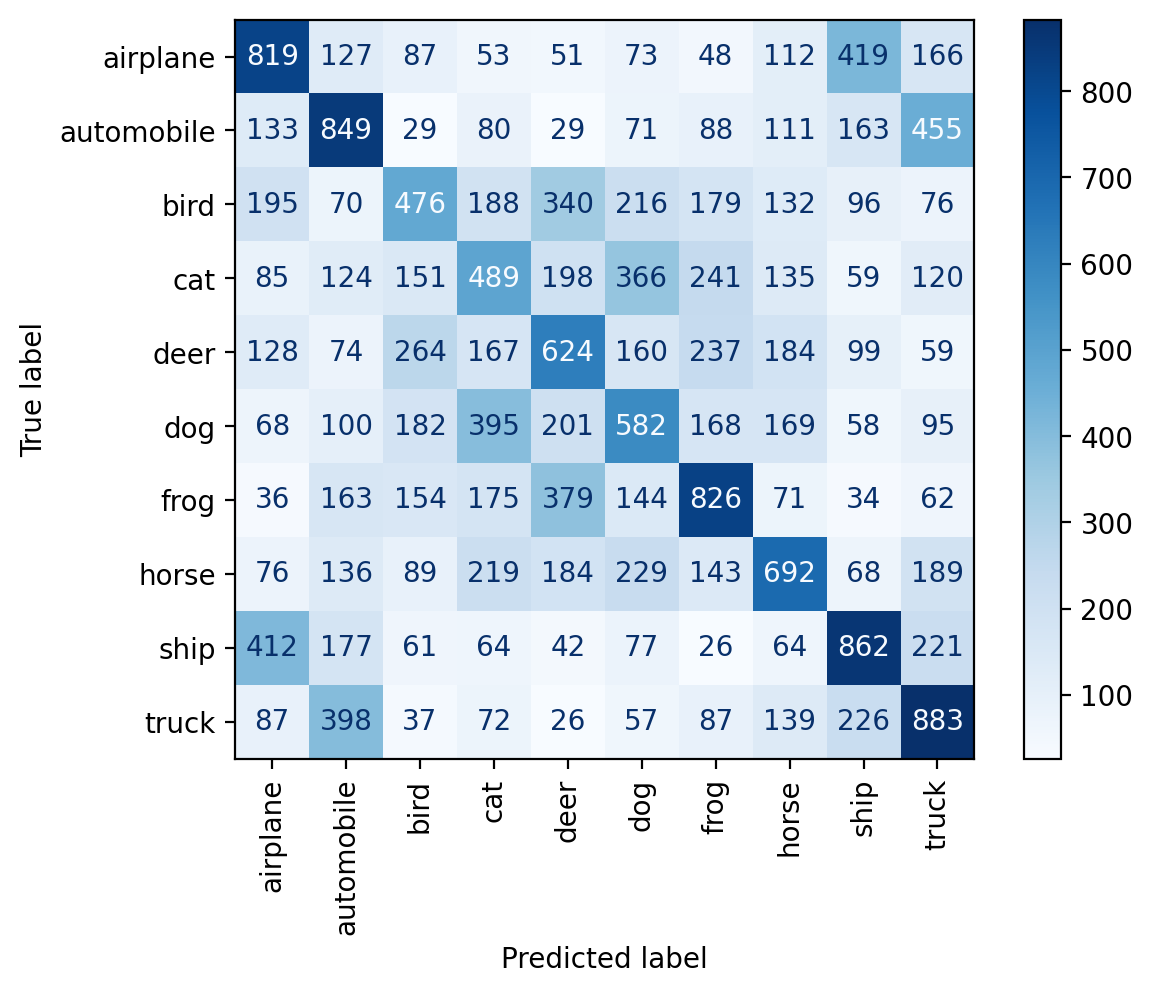

In [58]:
predict(resnet, dataset.classes, plot_confusion_matrix=True)

/home/nipun.batra/miniforge3/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


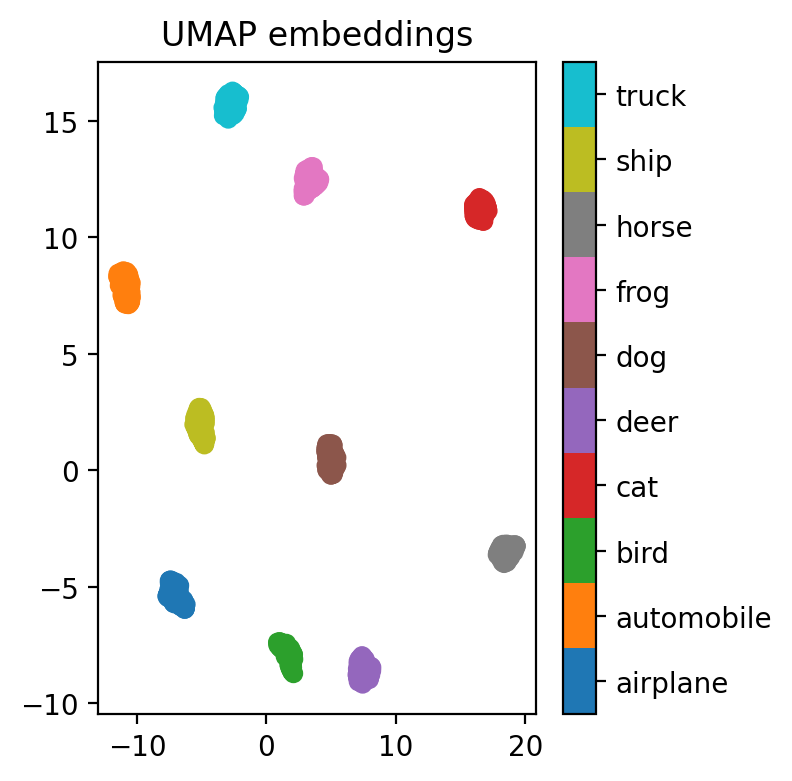

In [59]:
viz_embeddings(resnet, X[train_idx], y[train_idx], device)

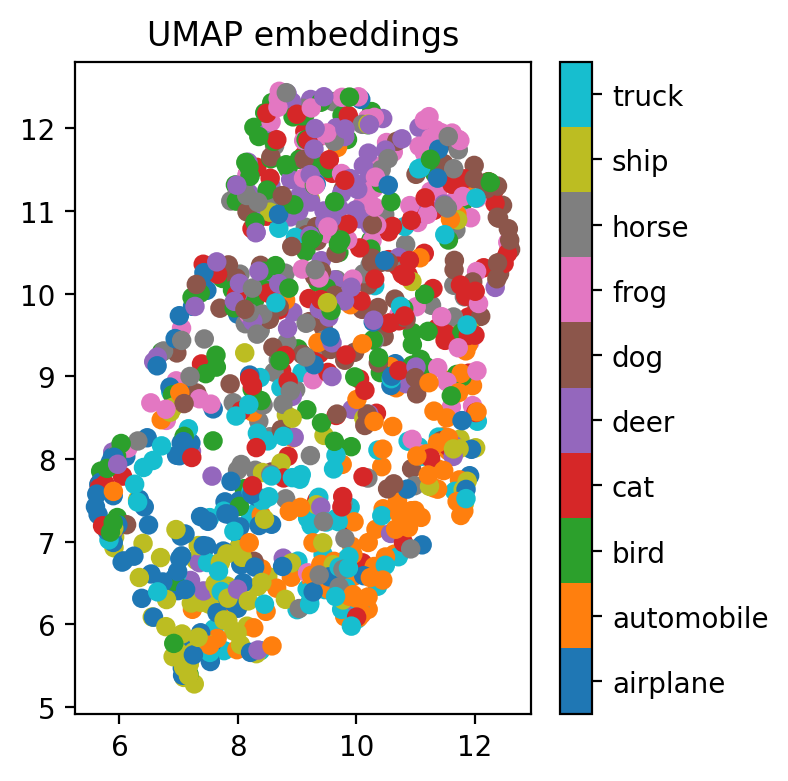

In [109]:
viz_embeddings(resnet, X[pool_idx[:1000]], y[pool_idx[:1000]], device)

In [62]:
### Train on train + pool
train_plus_pool_idx = torch.cat([train_idx, pool_idx])

resnet = ResNetClassifier(n_classes=10, dropout=0.1).to(device)

iter_losses, epoch_losses = train_fn(resnet, X[train_plus_pool_idx], y[train_plus_pool_idx], lr=3e-4,
                                        batch_size=2048, epochs=10, device=device)


loss: 1.5235: 100%|██████████| 15/15 [00:01<00:00,  9.73it/s]


Epoch 1/10 | Epoch loss: 1.9647


loss: 1.2412: 100%|██████████| 15/15 [00:01<00:00, 10.30it/s]


Epoch 2/10 | Epoch loss: 1.4511


loss: 1.0791: 100%|██████████| 15/15 [00:01<00:00, 10.19it/s]


Epoch 3/10 | Epoch loss: 1.1709


loss: 0.7901: 100%|██████████| 15/15 [00:01<00:00, 10.32it/s]


Epoch 4/10 | Epoch loss: 0.8828


loss: 0.5855: 100%|██████████| 15/15 [00:01<00:00, 10.26it/s]


Epoch 5/10 | Epoch loss: 0.5925


loss: 0.2997: 100%|██████████| 15/15 [00:01<00:00, 10.30it/s]


Epoch 6/10 | Epoch loss: 0.3404


loss: 0.1332: 100%|██████████| 15/15 [00:01<00:00, 10.32it/s]


Epoch 7/10 | Epoch loss: 0.1754


loss: 0.1185: 100%|██████████| 15/15 [00:01<00:00, 10.25it/s]


Epoch 8/10 | Epoch loss: 0.1079


loss: 0.0864: 100%|██████████| 15/15 [00:01<00:00, 10.31it/s]


Epoch 9/10 | Epoch loss: 0.0824


loss: 0.0673: 100%|██████████| 15/15 [00:01<00:00, 10.09it/s]


Epoch 10/10 | Epoch loss: 0.0618


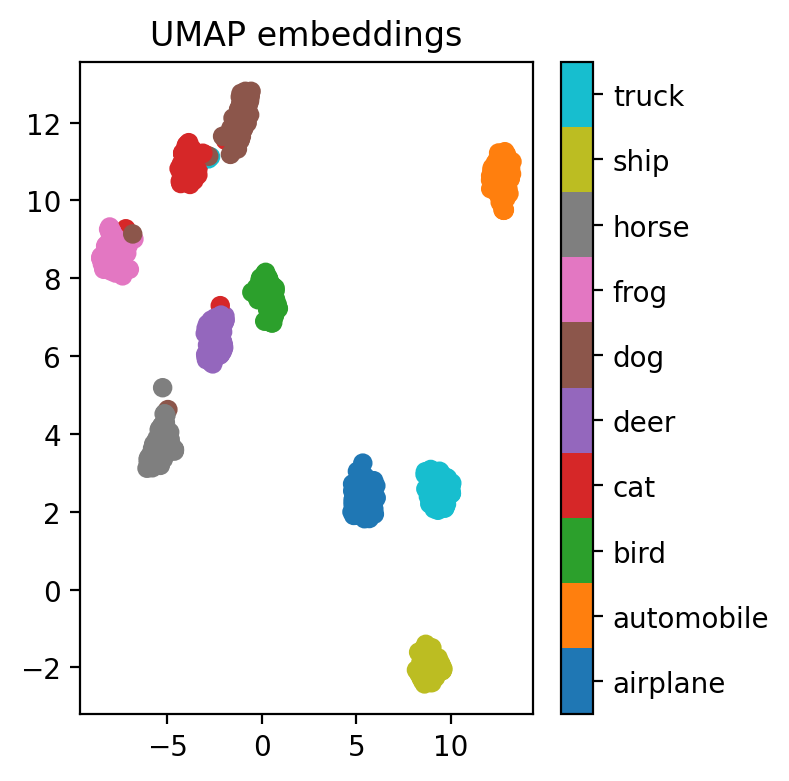

In [63]:
viz_embeddings(resnet, X[train_idx], y[train_idx], device)

### SSL
#### Task 1: Predict angle of rotation (0, 90, 180, 270) as a classification task

Create a dataset with rotated images and corresponding labels. We can now use a much larger dataset



In [64]:
X_train_plus_pool = torch.cat([X[train_idx], X[pool_idx]])
y_train_plus_pool = torch.cat([y[train_idx], y[pool_idx]])


X_train_plus_pool.shape, y_train_plus_pool.shape

(torch.Size([30000, 3, 32, 32]), torch.Size([30000]))

In [ ]:
transforms.func

In [65]:
X_ssl = []
y_ssl = []

angles_map = {0:0, 90:1, 180:2, 270:3}
for angle_rot in angles_map.keys():
    print(f"Angle: {angle_rot}")
    X_rot = transforms.functional.rotate(X_train_plus_pool, angle_rot)
    X_ssl.append(X_rot)
    y_ssl.append(torch.tensor([angles_map[angle_rot]]*len(X_rot)))
    
X_ssl = torch.cat(X_ssl)
y_ssl = torch.cat(y_ssl)

Angle: 0
Angle: 90
Angle: 180
Angle: 270


In [66]:
X_ssl.shape, y_ssl.shape

(torch.Size([120000, 3, 32, 32]), torch.Size([120000]))

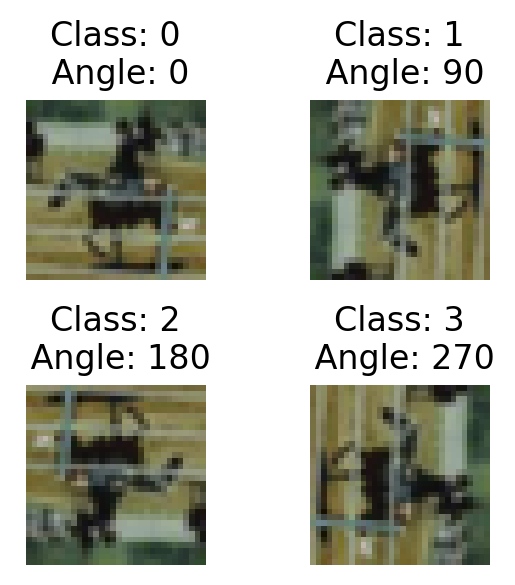

In [79]:
# Plot same image rotated at different angles
def plot_ssl(img_id):
    plt.figure(figsize=(3, 3))
    offset = len(X_train_plus_pool)
    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(X_ssl[offset*i + img_id].cpu().permute(1, 2, 0))
        plt.axis('off')
        plt.title(f"Class: {angles_map[i*90]}\n Angle: {i*90}")
    plt.tight_layout()
plot_ssl(2)

In [110]:
ssl_angle = ResNetClassifier(n_classes=4, dropout=0.1).to(device)

In [111]:
iter_losses, epoch_losses = train_fn(ssl_angle, X_ssl, y_ssl, lr=3e-4,
                                        batch_size=2048*16, epochs=48, device=device)


loss: 1.2478: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]


Epoch 1/48 | Epoch loss: 1.7943


loss: 1.0924: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]


Epoch 2/48 | Epoch loss: 1.5227


loss: 1.0204: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]


Epoch 3/48 | Epoch loss: 1.3932


loss: 0.9698: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Epoch 4/48 | Epoch loss: 1.3143


loss: 0.9160: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]


Epoch 5/48 | Epoch loss: 1.2447


loss: 0.8707: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]


Epoch 6/48 | Epoch loss: 1.1804


loss: 0.8154: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Epoch 7/48 | Epoch loss: 1.1112


loss: 0.7691: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]


Epoch 8/48 | Epoch loss: 1.0428


loss: 0.7181: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]


Epoch 9/48 | Epoch loss: 0.9630


loss: 0.7405: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]


Epoch 10/48 | Epoch loss: 0.9208


loss: 0.6117: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]


Epoch 11/48 | Epoch loss: 0.8301


loss: 0.5387: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Epoch 12/48 | Epoch loss: 0.7406


loss: 0.4544: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Epoch 13/48 | Epoch loss: 0.6383


loss: 0.4135: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


Epoch 14/48 | Epoch loss: 0.5473


loss: 0.3152: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]


Epoch 15/48 | Epoch loss: 0.4448


loss: 0.2242: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Epoch 16/48 | Epoch loss: 0.3321


loss: 0.1627: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]


Epoch 17/48 | Epoch loss: 0.2414


loss: 0.1183: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]


Epoch 18/48 | Epoch loss: 0.1692


loss: 0.0891: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]


Epoch 19/48 | Epoch loss: 0.1295


loss: 0.0579: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Epoch 20/48 | Epoch loss: 0.0791


loss: 0.0357: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]


Epoch 21/48 | Epoch loss: 0.0493


loss: 0.0173: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Epoch 22/48 | Epoch loss: 0.0274


loss: 0.0121: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]


Epoch 23/48 | Epoch loss: 0.0172


loss: 0.0069: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]


Epoch 24/48 | Epoch loss: 0.0104


loss: 0.0045: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]


Epoch 25/48 | Epoch loss: 0.0066


loss: 0.0027: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]


Epoch 26/48 | Epoch loss: 0.0041


loss: 0.0020: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


Epoch 27/48 | Epoch loss: 0.0028


loss: 0.0018:  25%|██▌       | 1/4 [00:00<00:02,  1.11it/s]


KeyboardInterrupt: 

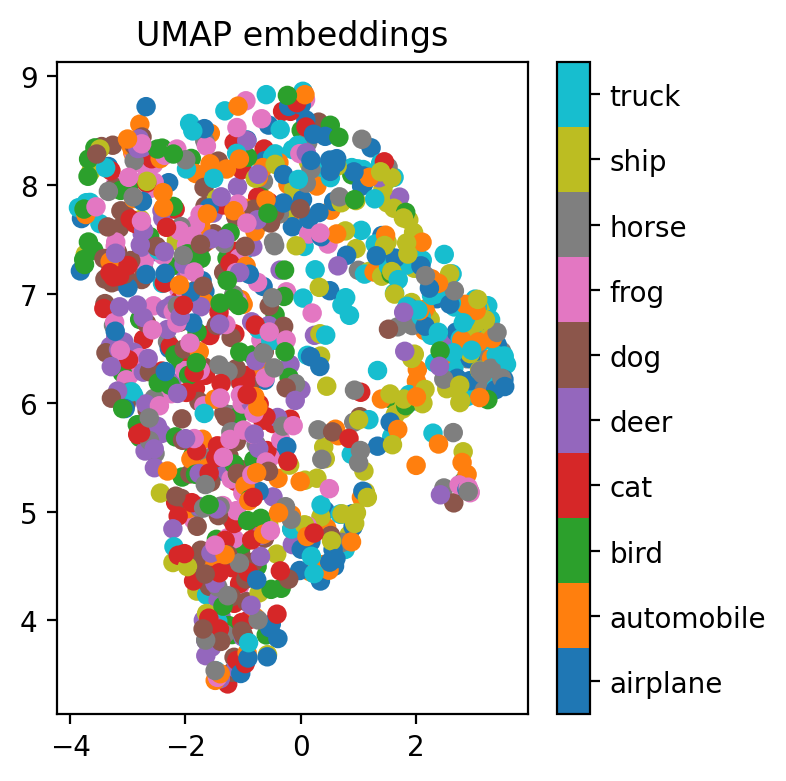

In [112]:
# Visualise the embeddings of the SSL model trained on angles dataset 
# (but wrt original 10 classes)
viz_embeddings(ssl_angle, X[train_idx], y[train_idx], device)

In [304]:
# Now, we can use the features from SSLAngle model to train the classifier on the original data

net_pretrained = Net().to(device)
net_pretrained.featurizer.load_state_dict(ssl_angle.featurizer.state_dict())

res_dict = train_fn(net_pretrained, X_train, y_train, nn.CrossEntropyLoss(), lr=3e-4, n_epochs=500)


Loss: 0.001218: 100%|██████████| 500/500 [00:02<00:00, 211.46it/s]


Accuracy Test: 20.30%
Accuracy Train: 100.00%


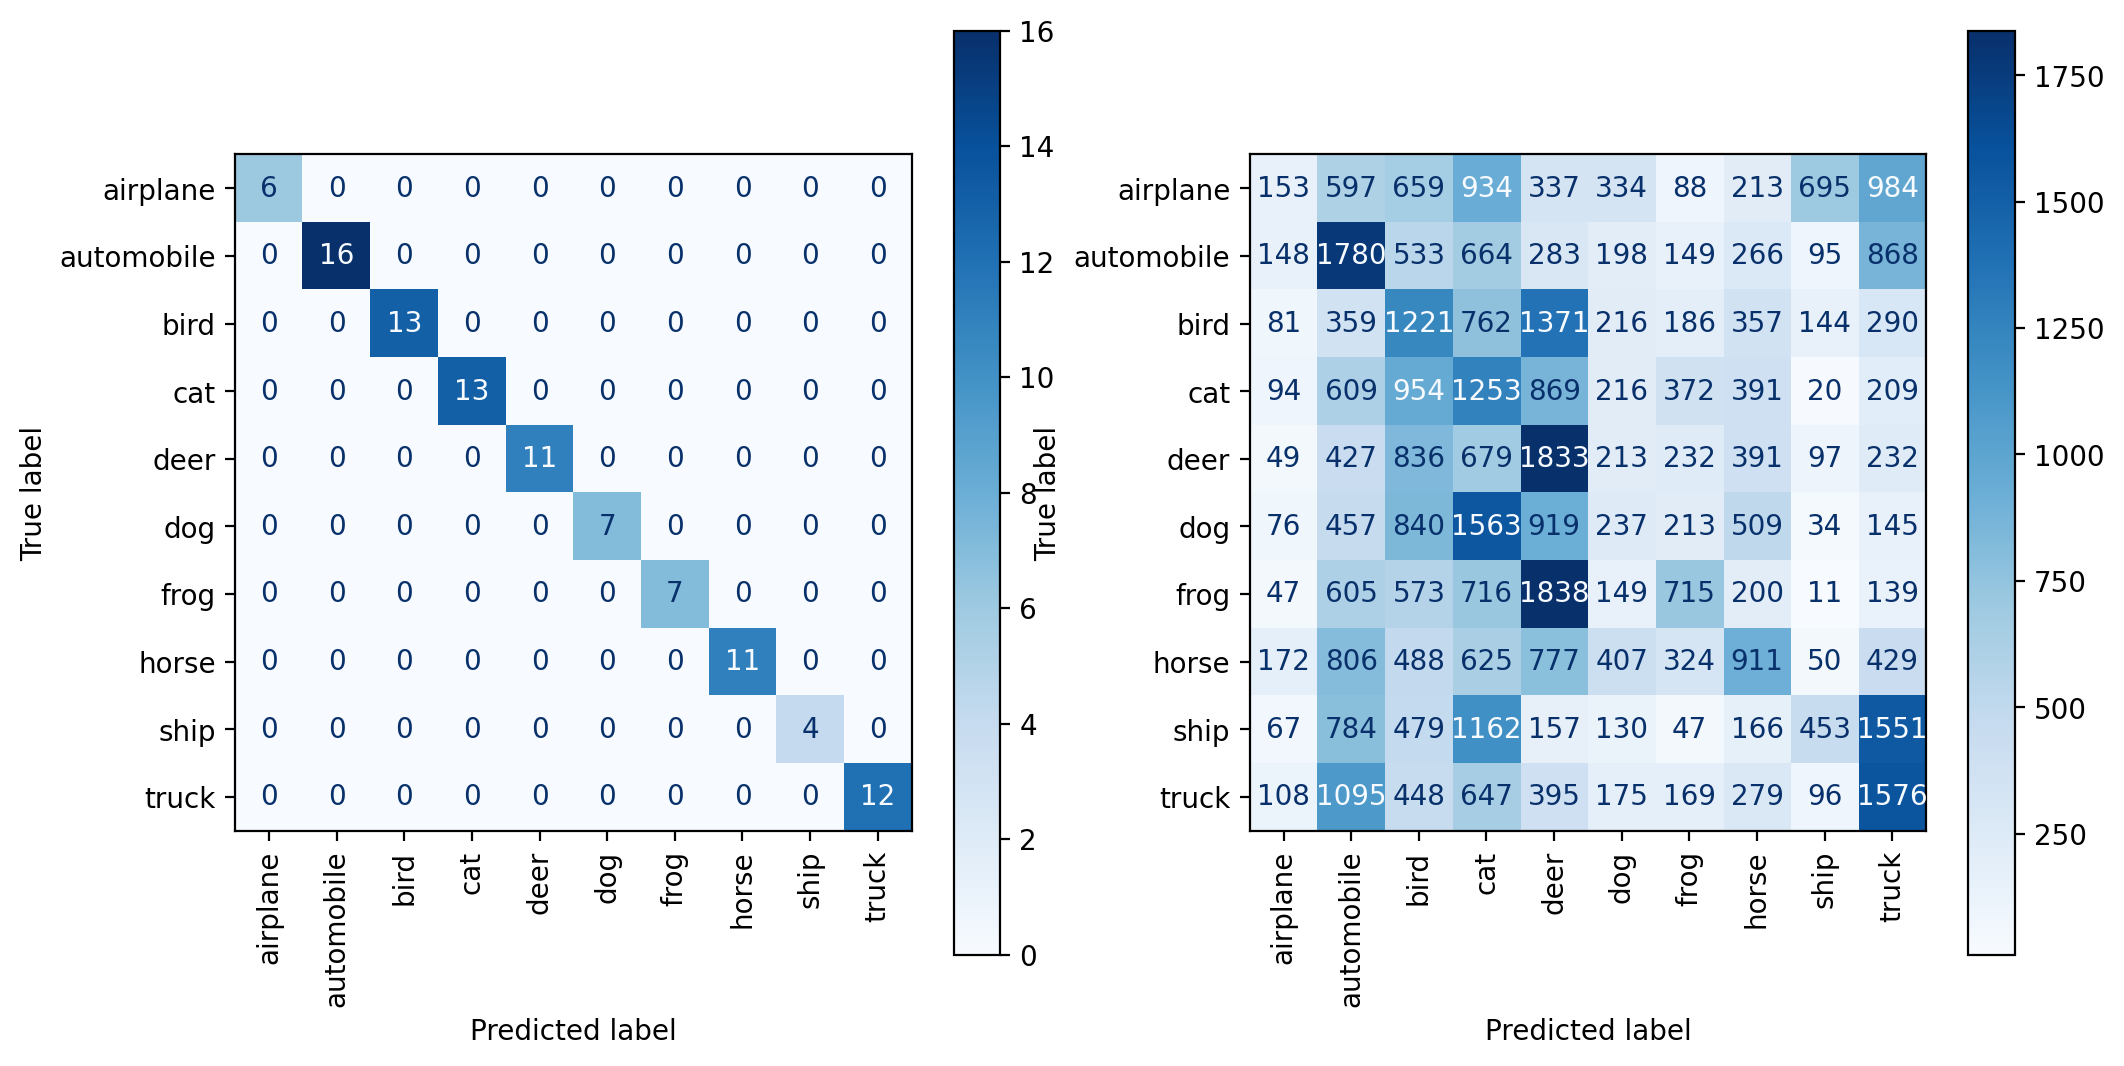

In [305]:
predict(net_pretrained)

In [87]:
# Print layer names, numel and parameters in each layer for "rn"

def print_layer_info(net):
    for name, param in net.named_parameters():
        print(f"Layer: {name}, Numel: {param.numel()}, Parameters: {param.shape}")

print_layer_info(rn)

Layer: conv1.weight, Numel: 9408, Parameters: torch.Size([64, 3, 7, 7])
Layer: bn1.weight, Numel: 64, Parameters: torch.Size([64])
Layer: bn1.bias, Numel: 64, Parameters: torch.Size([64])
Layer: layer1.0.conv1.weight, Numel: 36864, Parameters: torch.Size([64, 64, 3, 3])
Layer: layer1.0.bn1.weight, Numel: 64, Parameters: torch.Size([64])
Layer: layer1.0.bn1.bias, Numel: 64, Parameters: torch.Size([64])
Layer: layer1.0.conv2.weight, Numel: 36864, Parameters: torch.Size([64, 64, 3, 3])
Layer: layer1.0.bn2.weight, Numel: 64, Parameters: torch.Size([64])
Layer: layer1.0.bn2.bias, Numel: 64, Parameters: torch.Size([64])
Layer: layer1.1.conv1.weight, Numel: 36864, Parameters: torch.Size([64, 64, 3, 3])
Layer: layer1.1.bn1.weight, Numel: 64, Parameters: torch.Size([64])
Layer: layer1.1.bn1.bias, Numel: 64, Parameters: torch.Size([64])
Layer: layer1.1.conv2.weight, Numel: 36864, Parameters: torch.Size([64, 64, 3, 3])
Layer: layer1.1.bn2.weight, Numel: 64, Parameters: torch.Size([64])
Layer: lay

In [88]:
feature_extractor = timm.create_model('resnet18', features_only=True)


In [93]:
# Get the features from the feature extractor
with torch.no_grad():
    features = feature_extractor(X_train[:1].cpu())

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 512, 1, 1])

In [94]:
f = feature_extractor(torch.randn(1, 3, 32, 32).cpu())

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 512, 1, 1])

In [95]:
# Create the feature extractor
feature_extractor = timm.create_model('resnet18', features_only=True)

# Modify the input to match the expected size (e.g., 224x224)
input_tensor = torch.randn(1, 3, 224, 224)  # Assuming RGB images with a size of 224x224

# Ensure you are working on the CPU
f = feature_extractor(input_tensor.cpu())

In [101]:
len(f)

5

In [104]:
for m in timm.list_models():
    print(m)

bat_resnext26ts
beit_base_patch16_224
beit_base_patch16_384
beit_large_patch16_224
beit_large_patch16_384
beit_large_patch16_512
beitv2_base_patch16_224
beitv2_large_patch16_224
botnet26t_256
botnet50ts_256
caformer_b36
caformer_m36
caformer_s18
caformer_s36
cait_m36_384
cait_m48_448
cait_s24_224
cait_s24_384
cait_s36_384
cait_xs24_384
cait_xxs24_224
cait_xxs24_384
cait_xxs36_224
cait_xxs36_384
coat_lite_medium
coat_lite_medium_384
coat_lite_mini
coat_lite_small
coat_lite_tiny
coat_mini
coat_small
coat_tiny
coatnet_0_224
coatnet_0_rw_224
coatnet_1_224
coatnet_1_rw_224
coatnet_2_224
coatnet_2_rw_224
coatnet_3_224
coatnet_3_rw_224
coatnet_4_224
coatnet_5_224
coatnet_bn_0_rw_224
coatnet_nano_cc_224
coatnet_nano_rw_224
coatnet_pico_rw_224
coatnet_rmlp_0_rw_224
coatnet_rmlp_1_rw2_224
coatnet_rmlp_1_rw_224
coatnet_rmlp_2_rw_224
coatnet_rmlp_2_rw_384
coatnet_rmlp_3_rw_224
coatnet_rmlp_nano_rw_224
coatnext_nano_rw_224
convformer_b36
convformer_m36
convformer_s18
convformer_s36
convit_base
conv

In [105]:
rn2 =  timm.create_model('resnet18', pretrained=False)


Linear(in_features=512, out_features=1000, bias=True)

In [17]:
# Create a custom featurizer based on ResNet
class ResNetFeaturizer(nn.Module):
    def __init__(self):
        super(ResNetFeaturizer, self).__init__()
        # Create a ResNet feature extractor from the timm library
        feature_extractor = timm.create_model('resnet18', pretrained=True)
        feature_extractor = nn.Sequential(*list(feature_extractor.children())[:-1])  # Remove the final classification layers
        # add a FC layer to make the output size 400
        self.act = nn.GELU()
        self.linear = nn.Linear(512, 400)
        # Add self.linear as the last layer of the feature extractor
        feature_extractor = nn.Sequential(
            feature_extractor,
            self.act,
            self.linear
        )
        self.feature_extractor = feature_extractor
        
    def forward(self, x):
        return self.feature_extractor(x)
    
class ResNetClassification(nn.Module):
    def __init__(self):
        super(ResNetClassification, self).__init__()
        self.featurizer = ResNetFeaturizer()
        self.classifier = Classifier()
        
    def forward(self, x):
        x = self.featurizer(x)
        x = self.classifier(x)
        return x

In [18]:
rf = ResNetFeaturizer().to(device)
rf(torch.randn(1, 3, 224, 224).to(device)).shape

torch.Size([1, 400])

In [27]:
rn = ResNetClassification().to(device)
rn(torch.randn(1, 3, 32, 32).to(device)).shape

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 512, 1, 1])

In [21]:
class ResNetFeaturizer(nn.Module):
    def __init__(self):
        super(ResNetFeaturizer, self).__init__()
        # Create a ResNet feature extractor from the timm library
        feature_extractor = timm.create_model('resnet18', pretrained=False)
        feature_extractor = nn.Sequential(*list(feature_extractor.children())[:-1])  # Remove the final classification layers
        self.act = nn.GELU()
        self.linear = nn.Linear(512, 400)
        feature_extractor = nn.Sequential(
            feature_extractor,
            self.act,
            self.linear
        )
        self.feature_extractor = feature_extractor

    def forward(self, x):
        return self.feature_extractor(x)

class ResNetClassification(nn.Module):
    def __init__(self):
        super(ResNetClassification, self).__init__()
        self.featurizer = ResNetFeaturizer()
        self.classifier = Classifier()

    def forward(self, x):
        x = self.featurizer(x)
        print(x.shape)
        x = self.classifier(x)
        return x

# Set a consistent input size of 32x32 for both models
rf = ResNetFeaturizer().to(device)
rf(torch.randn(1, 3, 32, 32).to(device)).shape

rn = ResNetClassification().to(device)
rn(torch.randn(1, 3, 32, 32).to(device)).shape


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 512, 1, 1])

In [20]:
f = ResNetFeaturizer().to(device)
f(torch.randn(1, 3, 32, 32).to(device)).shape

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 512, 1, 1])